Disclaimer for any plotting: If the plot overlaps with any previous plot, please restart the kernel and run only relevant cells, i.e. do not run any other animation or plotting.

## Imports

In [25]:
# Set up imports
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
import random

## Part 1: Simulated Annealing


Simulated annealing is a stochastic approach to gradient descent to find the global minima of a given function. In this method, we perform a random action on our existing minima If it yields an even lower cost, we accept it as our new minima, but even if it increases the cost, we accept it as the best cost with a probability of $$P(\Delta E) = e^{-\frac{\Delta E}{kT}}$$

Here $\Delta E$ is the cost increase as a result of the new move, and $k$ is a constant.  $T$ is the present temperature. We do this to explore the search space effectively and make sure we don't converge to a local minima instead of looking for the global minima. 

In [26]:
def siman(func, start, T, decayrate):
    bestcost = 100000 # setting initial cost as some high value
    bestx = start # setting initial x guess
    rangemin, rangemax = -2, 2 
    fig, ax = plt.subplots()
    ax.plot(xbase, ybase)
    xall, yall = [], []
    lnall,  = ax.plot([], [], 'ro')
    lngood, = ax.plot([], [], 'go', markersize=10)
    while(True):
        dx = (np.random.random_sample() - 0.5) * T # random step 
        x = bestx + dx 
        y = func(x) # calculating cost
        # print(y)
        if(abs(y-bestcost) < 0.00001): # if step is too small, then stop
            break
        if y < bestcost: # if cost becomes lower, then select current position as best position so far
            bestcost = y
            bestx = x
            lngood.set_data(x, y)
        else:
            toss = np.random.random_sample() # if cost increases, select current position as best cost with some probability defined in the next line
            if toss < np.exp(-(y-bestcost)/T):
                bestcost = y
                bestx = x
                lngood.set_data(x, y)
            pass
        T = T * decayrate # decrease step size to converge eventually
        xall.append(x)
        yall.append(y)
    lnall.set_data(xall, yall)
    # print
    plt.show()
    return xall, yall

Next, we define our sample function and plot it:

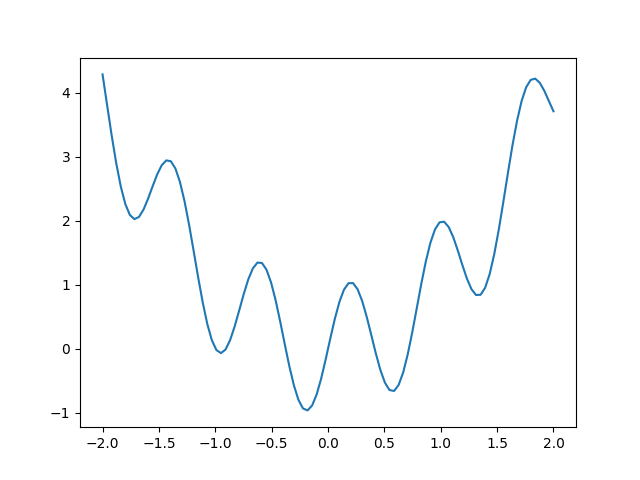

In [27]:
plt.close()
def yfunc(x):
    return x**2 + np.sin(8*x)

xbase = np.linspace(-2, 2, 100)
ybase = yfunc(xbase)
plt.plot(xbase, ybase)
plt.show()

Now, we perform simulated annealing on our function to find the global minima as shown:

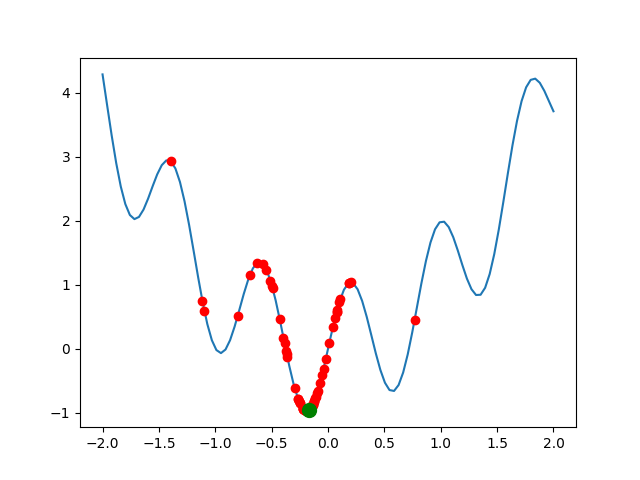

In [32]:
plt.close()
plotx1, ploty1 = siman(yfunc, -1, 3, 0.95)

## Animation:

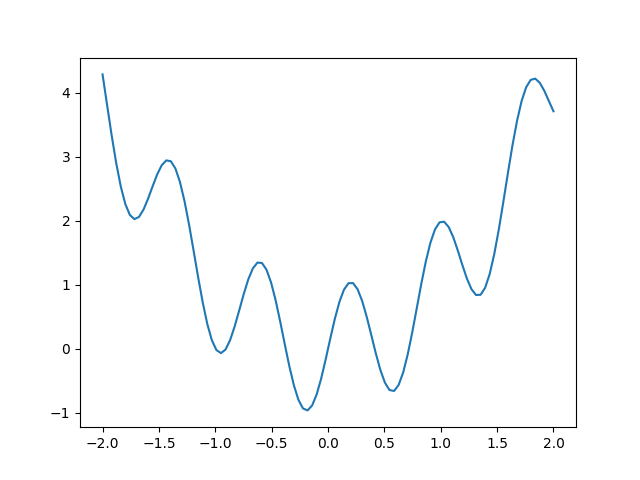

In [33]:
fig, ax = plt.subplots()
ax.plot(xbase, ybase)
lnall,  = ax.plot([], [], 'ro', markersize = 2)
lngood, = ax.plot([], [], 'go', markersize=5)

def onestepderiv(frame):
    global plotx1, ploty1 # using the point progression arrays generated in the above cell
    lnall.set_data(plotx1[:frame], ploty1[:frame]) # We plot the data upto the current frame number. This way, we add in one point every time
    lngood.set_data(plotx1[frame-1], ploty1[frame-1]) # Plots final point, i.e. best value upto that iteration
    # return lngood,

ani= FuncAnimation(fig, onestepderiv, frames=range(1, len(plotx1)), interval=100, repeat=False)
plt.show()

## Arbitrary function:

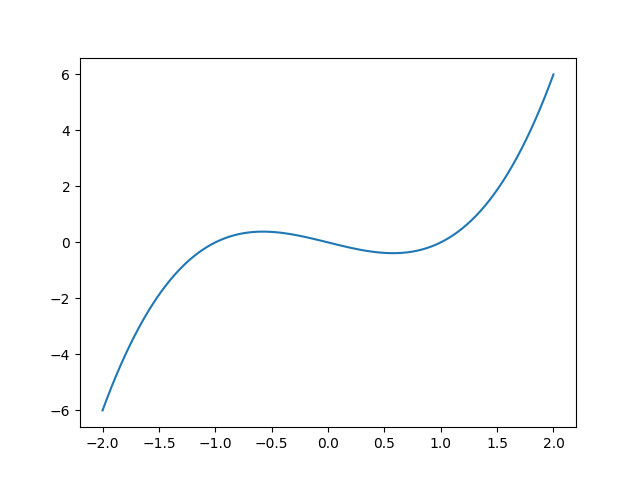

In [35]:
plt.close()
def yfunc1(x):
    return x**3 - x

xbase = np.linspace(-2, 2, 100)
ybase = yfunc1(xbase)
plt.plot(xbase, ybase)
plt.show()

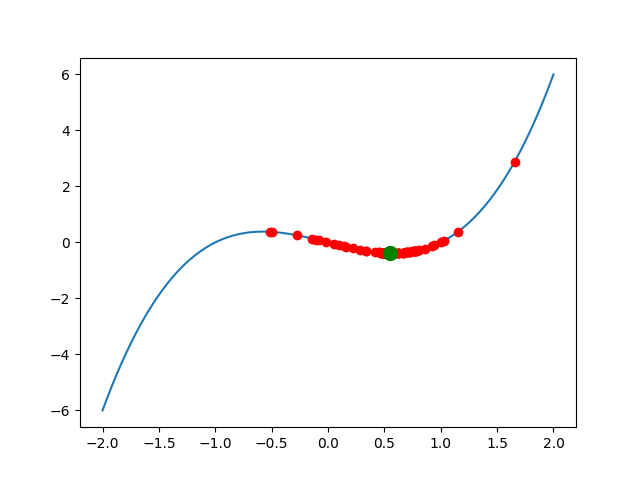

In [43]:
plt.close()
plotx5, ploty5 = siman(yfunc1, 0.1, 3, 0.95)

## Animation:

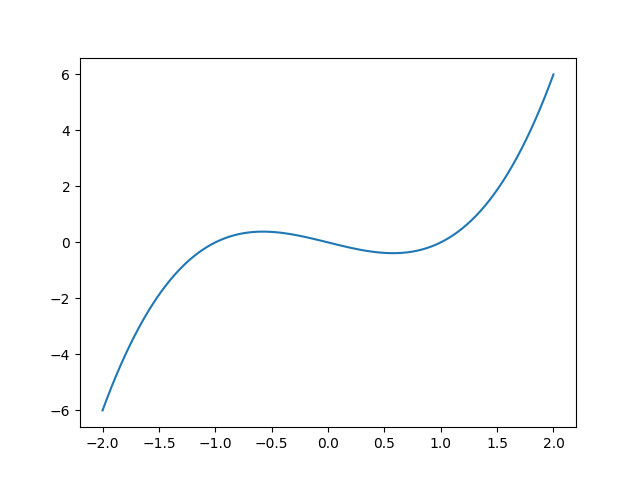

In [44]:
fig, ax = plt.subplots()
ax.plot(xbase, ybase)
lnall,  = ax.plot([], [], 'ro', markersize = 2)
lngood, = ax.plot([], [], 'go', markersize=5)

def onestepderiv(frame):
    global plotx5, ploty5 # using the point progression arrays generated in the above cell
    lnall.set_data(plotx5[:frame], ploty5[:frame]) # We plot the data upto the current frame number. This way, we add in one point every time
    lngood.set_data(plotx5[frame-1], ploty5[frame-1]) # Plots final point, i.e. best value upto that iteration
    # return lngood,

ani= FuncAnimation(fig, onestepderiv, frames=range(1, len(plotx5)), interval=100, repeat=False)
plt.show()

## Part 2: Travelling Salesman Problem

In this problem, we need to find the minimum distance to visit all the cities once, returning back to where we started. 

We start by reading our input file for the 10 cities case, and inputting the coordinates of the cities into an array, `coords`:

In [45]:
filename = 'tsp_10.txt'
with open(filename, 'r') as filehandle:
    data = filehandle.read().split('\n')
coords= [] # list for storing the coordinates of each city
for i in range(1, len(data)): 
    if data[i] == '':
        continue
    token = data[i]
    xy = token.split()
    coords.append([float(xy[0]), float(xy[1])])
coords = np.array(coords)
print(coords)

[[3.26 7.01]
 [6.77 3.82]
 [9.69 9.97]
 [7.4  0.33]
 [4.53 1.44]
 [1.91 3.67]
 [0.28 9.05]
 [6.36 3.98]
 [9.13 8.86]
 [5.99 4.36]]


We then define a function, `travelfunc`, which takes as input the permutation (order) of visiting cities, and returns the total distance travelled (including the return back to the starting city)

In [46]:
def travelfunc(x):
    dist = 0 # stores total distance travelled
    global coords
    for i in range(len(x)-1):
        c1 = x[i]
        c2 = x[i+1]
        dist += np.linalg.norm(coords[c1]-coords[c2])
    dist += np.linalg.norm(coords[x[-1]] - coords[x[0]]) # return to starting city
    return(dist)

### First approach: Random Permutation Function

In this approach, we define a function that has the independent variable (`x`) as the order of cities, and has the y value (total cost of that `x`) as the total distance for that permutation. 

In order to implement this, we import `random` to generate all possible permutations:

In [47]:
import itertools
import random

We now define a function `perm(n)` which returns a list of all the possible permutations for n cities:

In [48]:
def perm(n):
    temp = [i for i in range(n)]
    ans = list(itertools.permutations(temp))
    # random.shuffle(ans)
    return(ans)

Generating the list of all permutations for 10 cities:

In [49]:
permutations = perm(10)
# print(permutations)

We finally define our function `simanntravel10` to implement simulated annealing for travelling salesman. This function takes the function we defined above as the cost calculating function, and returns the least distance permutation.

In [50]:
def simanntravel10(func, start, T, decayrate):
    bestdist = 10000000
    bestx = start # this is the index of the permutation we are starting with in our "permutations" array
    global permutations
    nocities = 10
    for q in range(100):
        x = np.random.randint(0, len(permutations)) # choose a random index in the "permutations" array as our next guess
        curr = permutations[x] # getting the permutation corresponding to that index as the current guess for order of cities
        y = func(curr) # getting the distance for the current order
        if y < bestdist: # if this current order covers lesser distance than our previous least distance, then accept this as the best order so far
            bestdist = y
            bestx = x
        else:
            toss = np.random.random_sample() # if this current order covers more distance, select it with a probability as defined above
            if toss < np.exp(-(y-bestdist)/T):
                bestdist = y
                bestx = x
            pass
        T = T * decayrate # decrease the step size

    return(permutations[bestx], bestdist)

Example of the above implementation of travelling salesman:

In [51]:
simanntravel10(travelfunc, np.random.randint(0, len(permutations)), 8, 0.95)

((0, 1, 2, 8, 6, 5, 7, 4, 3, 9), 46.010555155910865)

This approach gives good values, but there is scope for improvement. Also, when we try to implement this function for 100 cities, we would have to generate the `permutations` array for 100 cities, which is not possible computationally, since it would take too much computation.

So, we try a new approach for our random step: instead of picking a random permutation, we pick two random cities in the current best permutation, and swap them. If the swapped permutation yields a lower distance, then we accept it as our current best permutation. Even if the distance increases, we accept it as our best guess with the same probability as above.

In [52]:
def simanntravel100(func, start, T, decayrate, noiters):
    
    bestx = start.copy() # this is a list of order of cities 
    bestdist = func(start) # get the distance of our starting permutation
    nocities = len(start) # number of cities we are considering; here, it is 100
    xnew = start.copy() 
    for q in range(noiters):
        ind1 = np.random.randint(1, nocities - 1) # considering our order starts with zero, we keep the first city fixed at 0 and swap between the rest of the cities, to avoid generating redundant cyclic permutations
        ind2 = np.random.randint(1, nocities - 1)
        while(ind1 == ind2):
            ind1 = np.random.randint(1, nocities - 1) # picking 2 unique indices to swap
        temp = xnew[ind1] # xnew is our new swapped permutation
        xnew[ind1] = xnew[ind2]
        xnew[ind2] = temp 
        y = func(xnew) # the distance after swapping
        if y < bestdist: # if swapped permutation has lower distance, then set it as new best guess
            bestdist = y
            bestx = xnew.copy()
        else: # probabilistically accepting higher distance permutation, for the sake of exploring the search space to find global minima
            toss = np.random.random_sample()
            if toss < np.exp(-(y-bestdist)/T):
                bestdist = y
                bestx = xnew.copy()
            pass
        T = T * decayrate # decrease Temperature
        xnew = bestx.copy()
        
    return(bestx, bestdist)

Now, we test our new logic on the initial 10 cities dataset:

In [53]:
# reading file and generating coordinates array
filename = 'tsp_10.txt'
with open(filename, 'r') as filehandle:
    data = filehandle.read().split('\n')
coords= []
for i in range(1, len(data)): 
    if data[i] == '':
        continue
    token = data[i]
    xy = token.split()
    coords.append([float(xy[0]), float(xy[1])])
coords = np.array(coords) 

Least distance is 34.07656139463668 for order 
[0, 6, 5, 4, 3, 1, 7, 9, 8, 2]


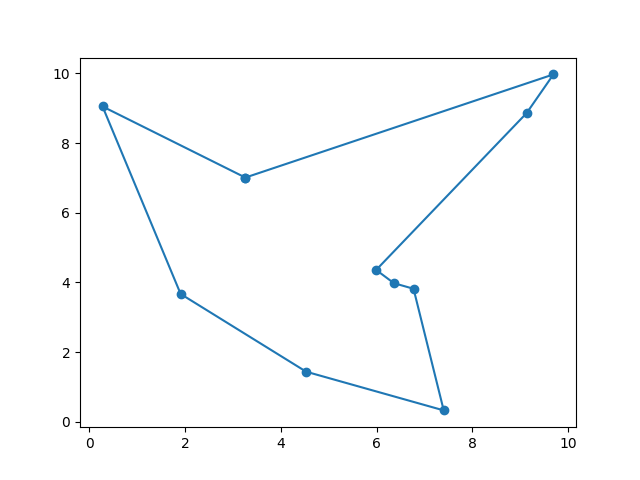

In [101]:
# if old plot is being displayed, rerun the cell
a = [0]
b = [i for i in range(1, 10)]
random.shuffle(b)
p = a + b # generating a random initial guess permutation with starting city as 0
bestorder, dist = simanntravel100(travelfunc, p, 8, 0.9, 1000) # lower T gives faster convergance; lower decay rate gives faster convergance; I have set the following T and decay rate values by trial and error
print(f"Least distance is {dist} for order \n{bestorder}")

# plotting
plt.close()
xplot = []
yplot = []
for q in bestorder:
    xplot.append(coords[q][0])
    yplot.append(coords[q][1])
xplot.append(xplot[0])
yplot.append(yplot[0])
plt.plot(xplot, yplot, 'o-')
plt.show()
# plt.close()

As we can see, this function performs much better than our initial implementation. The lowest distance I could get from this (by running multiple times) is below:

Least distance is 27.39950124176148 for order 
[0, 7, 3, 6, 4, 9, 1, 8, 2, 5]


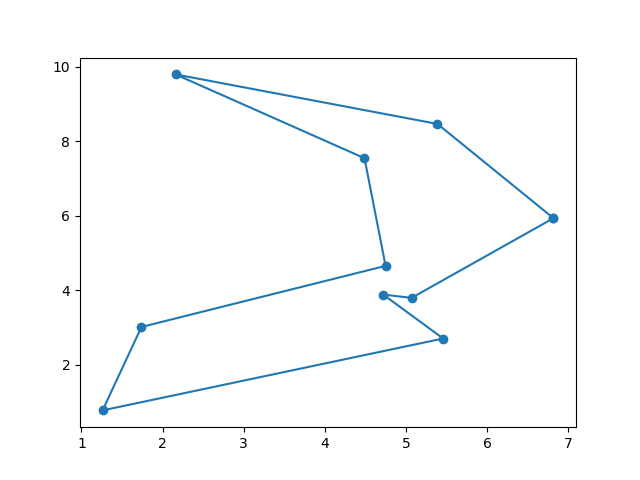

In [126]:
a = [0]
b = [i for i in range(1, 10)]
random.shuffle(b)
p = a + b # generating a random initial guess permutation with starting city as 0
bestorder, dist = simanntravel100(travelfunc, p, 8, 0.9, 1000) # lower T gives faster convergance; lower decay rate gives faster convergance; I have set the following T and decay rate values by trial and error
print(f"Least distance is {dist} for order \n{bestorder}")

# plotting
plt.close()
xplot = []
yplot = []
for q in bestorder:
    xplot.append(coords[q][0])
    yplot.append(coords[q][1])
xplot.append(xplot[0])
yplot.append(yplot[0])
plt.plot(xplot, yplot, 'o-')
plt.show()

Now, we test the same on the 100 cities dataset:

In [103]:
plt.close()

In [104]:
filename = 'tsp_100.txt'
with open(filename, 'r') as filehandle:
    data = filehandle.read().split('\n')
coords= []
for i in range(1, len(data)): 
    if data[i] == '':
        continue
    token = data[i]
    xy = token.split()
    coords.append([float(xy[0]), float(xy[1])])
coords = np.array(coords)

Least distance is 168.02764585508328 for order 
[0, 88, 17, 28, 91, 59, 97, 53, 90, 71, 76, 52, 39, 15, 61, 26, 78, 62, 33, 98, 85, 10, 77, 16, 6, 80, 21, 73, 64, 67, 23, 13, 45, 87, 74, 40, 35, 69, 66, 9, 70, 1, 37, 20, 18, 7, 27, 65, 34, 95, 63, 12, 42, 84, 50, 36, 22, 54, 96, 83, 43, 32, 46, 82, 58, 8, 99, 14, 93, 19, 30, 25, 86, 2, 79, 44, 81, 11, 29, 31, 55, 3, 41, 4, 89, 5, 94, 24, 38, 57, 72, 92, 60, 49, 48, 75, 51, 68, 56, 47]


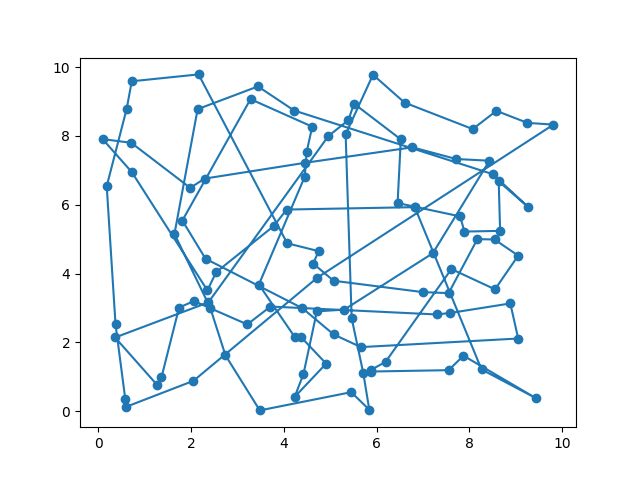

In [106]:
v = [i for i in range(1, 100)]
random.shuffle(v)
c = [0] + v # generating random initial guess permutation with 0 as the starting city
k = simanntravel100(travelfunc, c, 8, 0.95, 10000)
print(f"Least distance is {k[1]} for order \n{k[0]}") # least distance
# plotting
plt.close()
xplot2 = []
yplot2 = []
for q in k[0]:
    xplot2.append(coords[q][0])
    yplot2.append(coords[q][1])
xplot2.append(xplot2[0])
yplot2.append(yplot2[0])
# print(xplot2)
plt.plot(xplot2, yplot2, 'o-')
plt.show()

The best distance I could get for this dataset (by running multiple times) was:

In [845]:
v = [i for i in range(1, 100)]
random.shuffle(v)
c = [0] + v # randomizing starting permutation
k = simanntravel100(travelfunc, c, 8, 0.95, 10000)
print(k[1])

134.01189926055315
